In [1]:
import cv2
import os 
import matplotlib.pyplot as plt
import numpy as np 
from random import shuffle 
from tqdm import tqdm 
from keras.utils import to_categorical
import pandas as pd
LR = 1e-3
IMG_SIZE = 150
NUM_LABELS = 2

Using TensorFlow backend.


In [2]:
labels_df = pd.read_csv('oasis_cross-sectional-200.csv') ## 这里用了新的200 数据 所有有病的都标为1了 
labels_df = labels_df.drop(columns=['M/F','Hand','Age','Educ','SES','MMSE','eTIV','nWBV','ASF','Delay'])
labels_df = labels_df.fillna(0)
labels_df.head()

,ID,CDR
0,OAS1_0001_MR1,0
1,OAS1_0002_MR1,0
2,OAS1_0003_MR1,1
3,OAS1_0004_MR1,0
4,OAS1_0005_MR1,0


In [0]:
!unzip masked_gfc_imgs.zip

Archive:  masked_gfc_imgs.zip
replace masked_gfc_imgs/._OAS1_0273_MR1_mpr_n3_anon_111_t88_masked_gfc.hdr? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
TRAIN_DIR = '/content/masked_gfc_imgs'

In [4]:
'''Setting up the model which will help with tensorflow models'''
MODEL_NAME = 'Alzheimer-{}-{}.model'.format(LR, '6conv-basic') 
  
'''Labelling the dataset'''


training_test_data = [] 
y_train_test = []
for img in tqdm(os.listdir(TRAIN_DIR)):
    path = os.path.join(TRAIN_DIR, img)
    imgs = np.fromfile(path, dtype=np.int16)
    if len(imgs)==6443008:
        names = img.split('_mpr')[0]
        for i in range(0,200): ## 这里有调整
          if list(labels_df['ID'])[i]== names:
            imgs = imgs.reshape(176,208,176)
            #imgs = cv2.resize(imgs, (IMG_SIZE,IMG_SIZE))
            for j in range(0,40):
              images = imgs[j,:,:]
              image = cv2.resize(images, (IMG_SIZE,IMG_SIZE))
              training_test_data.append(np.array(image))
              for i in range(0,200):
                if list(labels_df['ID'])[i]== names:
                    labels = list(labels_df['CDR'])[i]
                    y_train_test.append(np.array(labels))
            
      

100%|██████████| 437/437 [01:02<00:00,  6.95it/s]


In [5]:
len(training_test_data)

8000

In [6]:
y_train = np.asarray(y_train_test[:5000])
y_test = np.asarray(y_train_test[5000:])
print(y_test.size)

3000


In [7]:
x_train = np.asarray(training_test_data[:5000])
x_test = np.asarray(training_test_data[5000:])
print(x_test.size)
print(x_train.size)
X_train = x_train.reshape(-1,IMG_SIZE,IMG_SIZE)
X_test = x_test.reshape(-1,IMG_SIZE*IMG_SIZE)
print(X_test.shape)
print(X_train.shape)
print(X_train.shape[0])

67500000
112500000
(3000, 22500)
(5000, 150, 150)
5000


In [8]:
for i in range (5000):
    X = X_train[i].reshape(IMG_SIZE,IMG_SIZE)
    flip_1 = np.fliplr(X)
    X_train = np.append(X_train,flip_1.reshape(-1,IMG_SIZE,IMG_SIZE), axis=0)
    

print(X_train.shape) 

np.save('/content/x_2D_balanced_aum_data.npy',  X_train)   


(10000, 150, 150)


In [9]:
y_train = np.append(y_train,y_train, axis=0)
print(y_train.shape) 
np.save('/content/y_2D_balanced_aum_data.npy',  y_train)

(10000,)


In [10]:
## Data
# one-hot encoding:
y_train_OH = to_categorical(y_train, NUM_LABELS)
y_test_OH = to_categorical(y_test, NUM_LABELS)
print(y_test_OH.shape)

(3000, 2)


In [11]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
model = Sequential()
model.add(Dense(128, input_shape=(IMG_SIZE*IMG_SIZE,),activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
X_train = X_train.reshape(-1,IMG_SIZE*IMG_SIZE)

In [13]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

epochs = 15

history = model.fit(X_train, 
                    y_train_OH, 
                    epochs=epochs, 
                    batch_size=256,
                    verbose=1,
                    validation_data=(X_test, y_test_OH))

Instructions for updating:
Use tf.cast instead.
Train on 10000 samples, validate on 3000 samples
Epoch 1/15
10000/10000 [==============================] - 2s 208us/step - loss: 4.4773 - acc: 0.5266 - val_loss: 4.7738 - val_acc: 0.4697
Epoch 2/15
10000/10000 [==============================] - 1s 102us/step - loss: 4.6317 - acc: 0.5183 - val_loss: 4.9725 - val_acc: 0.4767
Epoch 3/15
10000/10000 [==============================] - 1s 101us/step - loss: 4.5713 - acc: 0.5313 - val_loss: 4.7694 - val_acc: 0.4867
Epoch 4/15
10000/10000 [==============================] - 1s 102us/step - loss: 4.3451 - acc: 0.5466 - val_loss: 4.5406 - val_acc: 0.4917
Epoch 5/15
10000/10000 [==============================] - 1s 102us/step - loss: 3.9850 - acc: 0.5493 - val_loss: 4.1486 - val_acc: 0.4913
Epoch 6/15
10000/10000 [==============================] - 1s 102us/step - loss: 3.7584 - acc: 0.5526 - val_loss: 4.0687 - val_acc: 0.4903
Epoch 7/15
10000/10000 [==============================] - 1s 102us/step - l

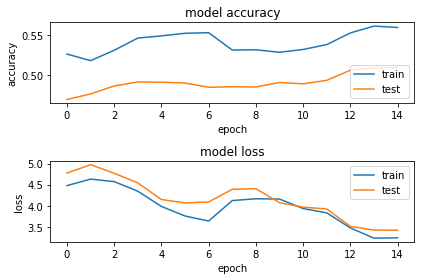

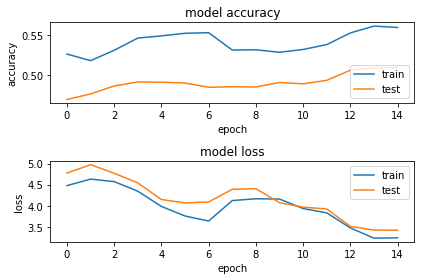

In [14]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [16]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
print(X_train.shape)
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
print(X_train.shape)

(10000, 1, 150, 150)
(10000, 1, 150, 150)


In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

In [18]:
model = Sequential()
  
model.add(Conv2D(18, (3, 3), input_shape=(1,IMG_SIZE,IMG_SIZE), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))    
model.add(Conv2D(6, (3, 3), input_shape=(1,IMG_SIZE,IMG_SIZE), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(2, activation='softmax'))
  
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 148, 148)      180       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 49, 49)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 49, 49)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 47, 47)         978       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 23, 23)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 23, 23)         0         
___________________________

In [19]:
# Fit the model
history = model.fit(X_train, y_train_OH, validation_data=(X_test, y_test_OH), epochs=100, batch_size=200)

Train on 10000 samples, validate on 3000 samples
Epoch 1/100
10000/10000 [==============================] - 5s 518us/step - loss: 0.6869 - acc: 0.5315 - val_loss: 0.6789 - val_acc: 0.5300
Epoch 2/100
10000/10000 [==============================] - 3s 302us/step - loss: 0.6401 - acc: 0.6122 - val_loss: 0.6101 - val_acc: 0.6660
Epoch 3/100
10000/10000 [==============================] - 3s 303us/step - loss: 0.6031 - acc: 0.6593 - val_loss: 0.5926 - val_acc: 0.6807
Epoch 4/100
10000/10000 [==============================] - 3s 307us/step - loss: 0.5790 - acc: 0.6798 - val_loss: 0.5746 - val_acc: 0.6817
Epoch 5/100
10000/10000 [==============================] - 3s 313us/step - loss: 0.5765 - acc: 0.6835 - val_loss: 0.5742 - val_acc: 0.6803
Epoch 6/100
10000/10000 [==============================] - 3s 345us/step - loss: 0.5622 - acc: 0.6913 - val_loss: 0.5747 - val_acc: 0.6790
Epoch 7/100
10000/10000 [==============================] - 3s 337us/step - loss: 0.5540 - acc: 0.6977 - val_loss: 0.5

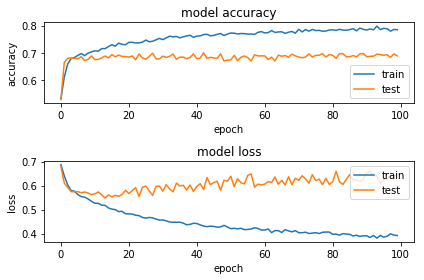

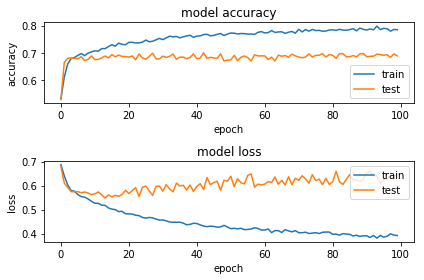

In [20]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [21]:
a,b = 0,0
for i in range (len(X_test)):
    if model.predict_classes(X_test[i].reshape(1, 1, 150,150))!=y_test[i]:
        if y_test[i]==0:
            a =a+1
        elif y_test[i]==1:
            b =b+1
        
        
print("mislabeled 0",a,"times") 
print("mislabeled 1",b,"times")

mislabeled 0 247 times
mislabeled 1 685 times


In [22]:
score = model.evaluate(X_test, y_test_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.647196763386329
Test accuracy: 0.6893333333333334


In [0]:
y_train_test = np.append(y_train_test,y_train_test)
print(y_train_test.shape) 
np.save('/content/y_2D_balanced_aum_data.npy',  y_train_test)

(11600,)


In [0]:
y_train_test = np.load('y_2D_balanced_aum_data.npy')
training_test_data = np.load('train_test_2D_balanced_aum_data.npy')

In [0]:
y_train = np.asarray(y_train_test[:7000])
y_test = np.asarray(y_train_test[7000:])
print(y_test.size)

4600


In [0]:
x_train = np.asarray(training_test_data[:7000])
x_test = np.asarray(training_test_data[7000:])
print(x_test.size)
X_train = x_train.reshape(-1,IMG_SIZE*IMG_SIZE)
X_test = x_test.reshape(-1,IMG_SIZE*IMG_SIZE)
print(X_test.shape)
print(X_train.shape[0])

103500000
(4600, 22500)
7000


In [0]:
## Data
# one-hot encoding:
y_train_OH = to_categorical(y_train, NUM_LABELS)
y_test_OH = to_categorical(y_test, NUM_LABELS)
print(y_test_OH.shape)

(4600, 2)


In [0]:
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
model = Sequential()
model.add(Dense(128, input_shape=(IMG_SIZE*IMG_SIZE,),activation='relu'))
model.add(Dense(2,activation='relu'))
model.add(Activation('softmax'))


In [0]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

epochs = 15

history = model.fit(X_train, 
                    y_train_OH, 
                    epochs=epochs, 
                    batch_size=256,
                    verbose=1,
                    validation_data=(X_test, y_test_OH))

Instructions for updating:
Use tf.cast instead.
Train on 7000 samples, validate on 4600 samples
Epoch 1/15
7000/7000 [==============================] - 5s 670us/step - loss: 3.5455 - acc: 0.4924 - val_loss: 3.6461 - val_acc: 0.4987
Epoch 2/15
7000/7000 [==============================] - 1s 143us/step - loss: 3.6198 - acc: 0.4900 - val_loss: 3.6235 - val_acc: 0.4961
Epoch 3/15
7000/7000 [==============================] - 1s 146us/step - loss: 3.6297 - acc: 0.4884 - val_loss: 3.5574 - val_acc: 0.4970
Epoch 4/15
7000/7000 [==============================] - 1s 145us/step - loss: 3.4255 - acc: 0.4889 - val_loss: 3.3045 - val_acc: 0.5039
Epoch 5/15
7000/7000 [==============================] - 1s 145us/step - loss: 3.1349 - acc: 0.4961 - val_loss: 3.2378 - val_acc: 0.5052
Epoch 6/15
7000/7000 [==============================] - 1s 146us/step - loss: 3.0494 - acc: 0.5001 - val_loss: 3.0868 - val_acc: 0.5067
Epoch 7/15
7000/7000 [==============================] - 1s 147us/step - loss: 2.9052 - a

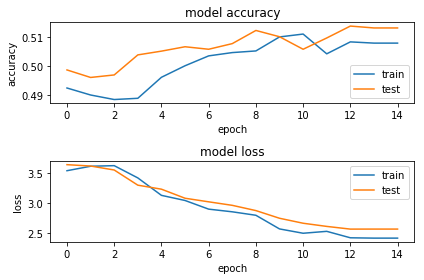

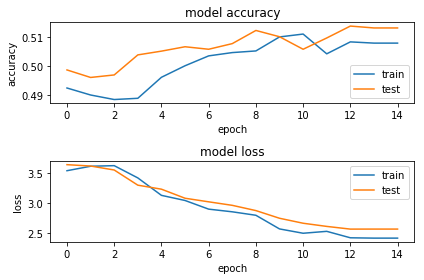

In [0]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

In [0]:
# reshape to be [samples][pixels][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, IMG_SIZE, IMG_SIZE).astype('float32')
print(X_train.shape)
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
print(X_train.shape)

(7000, 1, 150, 150)
(7000, 1, 150, 150)


In [0]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
# fix random seed for reproducibility
seed = 42
numpy.random.seed(seed)

In [0]:
model = Sequential()
  
model.add(Conv2D(18, (3, 3), input_shape=(1,IMG_SIZE,IMG_SIZE), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.4))    
model.add(Conv2D(6, (3, 3), input_shape=(1,IMG_SIZE,IMG_SIZE), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
  
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))  
model.add(Dense(2, activation='softmax'))
  
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 18, 148, 148)      180       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 49, 49)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 49, 49)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 47, 47)         978       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 23, 23)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 23, 23)         0         
___________________________

In [0]:
# Fit the model
history = model.fit(X_train, y_train_OH, validation_data=(X_test, y_test_OH), epochs=100, batch_size=200)

Train on 7000 samples, validate on 4600 samples
Epoch 1/100
7000/7000 [==============================] - 7s 954us/step - loss: 0.8442 - acc: 0.5004 - val_loss: 0.6929 - val_acc: 0.5083
Epoch 2/100
7000/7000 [==============================] - 4s 528us/step - loss: 0.7022 - acc: 0.5043 - val_loss: 0.6930 - val_acc: 0.5139
Epoch 3/100
7000/7000 [==============================] - 4s 527us/step - loss: 0.6982 - acc: 0.4996 - val_loss: 0.6930 - val_acc: 0.4987
Epoch 4/100
7000/7000 [==============================] - 4s 526us/step - loss: 0.6986 - acc: 0.5021 - val_loss: 0.6931 - val_acc: 0.4937
Epoch 5/100
7000/7000 [==============================] - 4s 526us/step - loss: 0.6941 - acc: 0.5067 - val_loss: 0.6929 - val_acc: 0.4957
Epoch 6/100
7000/7000 [==============================] - 4s 527us/step - loss: 0.6950 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.4946
Epoch 7/100
7000/7000 [==============================] - 4s 524us/step - loss: 0.6952 - acc: 0.5046 - val_loss: 0.6932 - val_acc: 

In [0]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

NameError: ignored

In [0]:
a,b = 0,0
for i in range (len(X_test)):
    if model.predict_classes(X_test[i].reshape(1, 1, 150,150))!=y_test[i]:
        if y_test[i]==0:
            a =a+1
        elif y_test[i]==1:
            b =b+1
        
        
print("mislabeled 0",a,"times") 
print("mislabeled 1",b,"times")

mislabeled 0 1787 times
mislabeled 1 170 times


In [0]:
score = model.evaluate(X_test, y_test_OH, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6497668393798497
Test accuracy: 0.5745652172876441
